# 0. Install required python libraries

In [1]:
!pip -qq install elasticsearch pandas datasets scikit-learn numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.4/979.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 1.1 MB/s eta 0:00:00


# 1. Connect to Elasticsearch
First, we need to establish a secure connection to your Elastic Serverless instance. We will use `getpass` to handle the API Key securely so it doesn't appear in your history.

In [2]:
# !pip install elasticsearch pandas datasets numpy

from elasticsearch import Elasticsearch
from getpass import getpass
import numpy as np

print("--- Elastic Connection Setup ---")
ELASTIC_URL = input("Enter Elastic URL: ")
ELASTIC_API_KEY = getpass("Enter Elastic API Key: ")

client = Elasticsearch(
    hosts=ELASTIC_URL,
    api_key=ELASTIC_API_KEY,
    request_timeout=30
)

try:
    info = client.info()
    print(f"\n✅ Connected to Elastic")
except Exception as e:
    print(f"\n❌ Connection failed: {e}")

--- Elastic Connection Setup ---
Enter Elastic URL: https://chatty-mcchatbot-c0f827.es.us-east-1.aws.elastic.cloud:443
Enter Elastic API Key: ··········

✅ Connected to Elastic


# 2. Load and Sample Data
We will use the **DBPedia-14** dataset (specifically the "Film" category) to create a realistic test corpus.

To start, we will load a fixed sample of **2,500 movies**. This is large enough to test vector search accuracy but small enough to run quickly in this notebook.

In [3]:
import pandas as pd
from datasets import load_dataset

print("Loading DBPedia-14 dataset...")
ds = load_dataset("dbpedia_14", split="train")

# Filter for "Film" (Label 11)
df = pd.DataFrame(ds)
df = df[df['label'] == 11]

# We take an initial sample of 2,500 for the main tutorial
df_sample = df.sample(2500, random_state=42).reset_index(drop=True)

print(f"✅ Dataset ready: {len(df_sample)} movie summaries.")

Loading DBPedia-14 dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dbpedia_14/train-00000-of-00001.parquet:   0%|          | 0.00/106M [00:00<?, ?B/s]

dbpedia_14/test-00000-of-00001.parquet:   0%|          | 0.00/13.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/70000 [00:00<?, ? examples/s]

✅ Dataset ready: 2500 movie summaries.


# 3. Ingestion: creating the "Server-Side Ground Truth"
This is the most critical part of the experiment setup. To measure accuracy, we need a "Gold Standard" to compare against.

We will map the `content` field twice in the same index:
1.  **`content` (HNSW):** This uses the default `semantic_text` settings. It is optimized for speed and scale using the **HNSW** graph algorithm and likely uses **BBQ (Binary Quantization)**. This is the "Test Subject."
2.  **`content.raw` (Flat):** We explicitly configure this sub-field to use `type: "flat"`. This forces Elasticsearch to perform a **Brute-Force Exact Scan** of the full Float32 vectors. This is the "Control Group" (Ground Truth).

By querying both fields and comparing the results, we can measure exactly how much accuracy we trade for speed.

We will be using the **Jina Embedding V5 Text Model** for this small test

In [5]:
from elasticsearch import helpers
import time

index_name = "movies-recall-demo"

# --- 1. Define Dual Mapping ---
mapping = {
    "properties": {
        "title": {"type": "text"},
        "content": {
            "type": "semantic_text",
            "inference_id": ".jina-embeddings-v5-text-small",
            "fields": {
                # The "Control Group": Forces exact brute-force scan
                "raw": {
                    "type": "semantic_text",
                    "inference_id": ".jina-embeddings-v5-text-small",
                    "index_options": {
                        "dense_vector": {
                            "type": "flat"
                        }
                    }
                }
            }
        }
    }
}

# --- 2. Reset Index ---
if client.indices.exists(index=index_name):
    client.indices.delete(index=index_name)
    print(f"♻️  Refreshing index '{index_name}'...")
else:
    print(f"🆕 Creating new index '{index_name}'...")

client.indices.create(index=index_name, mappings=mapping)
print(f"✅ Index ready with Flat + HNSW fields.")

# --- 3. Bulk Index ---
actions = []
print(f"Preparing {len(df_sample)} documents...")

for i, row in df_sample.iterrows():
    actions.append({
        "_index": index_name,
        "_id": str(i),
        "_source": {
            "title": row['title'],
            "content": row['content']
        }
    })

chunk_size = 500
print(f"🚀 Indexing documents (Chunk Size = {chunk_size})...")

success, errors = helpers.bulk(
    client, actions, chunk_size=chunk_size,
    raise_on_error=False, stats_only=False
)

if errors:
    print(f"\n⚠️ CRITICAL: {len(errors)} documents failed to index.")
    print(errors[0])
else:
    print(f"✅ Ingestion complete! Indexed {success} documents.")
    print("Waiting 10 seconds for inference to catch up...")
    time.sleep(10)

♻️  Refreshing index 'movies-recall-demo'...
✅ Index ready with Flat + HNSW fields.
Preparing 2500 documents...
🚀 Indexing documents (Chunk Size = 500)...
✅ Ingestion complete! Indexed 2500 documents.
Waiting 10 seconds for inference to catch up...


# 4. Phase 1: The Baseline Recall Test
Now we run the experiment. We will calculate **Recall@10** to measure the performance of the HNSW algorithm.

**How this works:**
1.  **Select 50 Random Queries:** We pick 50 movies from our index to serve as search queries.
2.  **Get the "Perfect" Answer:** We query the `content.raw` (Flat) field. Because this uses a brute-force scan of uncompressed vectors, the top 10 results are mathematically guaranteed to be the closest neighbors.
3.  **Get the "Real-World" Answer:** We query the `content` (HNSW) field using the exact same text. This uses the fast, approximate graph search (which might use quantization).
4.  **Compare:** We count how many documents overlap.
    * If the HNSW search finds 9 of the same movies as the Flat search, the Recall is **0.9 (90%)**.

**Code Walkthrough:**
* `test_indices`: Randomly selects ID numbers to use as queries.
* `client.search(..., field="content.raw")`: The slow, exact search (Truth).
* `client.search(..., field="content")`: The fast, approximate search (Test).
* `set(true_ids).intersection(...)`: The math that calculates the score.

In [10]:
# --- 1. Setup Experiment ---
num_queries = 50
test_indices = np.random.choice(len(df_sample), num_queries, replace=False)
recall_scores = []

print(f"--- Phase 1: Baseline Evaluation ---")
print(f"Running {num_queries} queries...")
print("(Comparing 'content' [HNSW] against 'content.raw' [Exact])")

for idx in test_indices:
    query_text = df_sample.iloc[idx]['content']

    # --- A. Get Ground Truth (Server-Side Exact) ---
    # Query the 'content.raw' field (FLAT Index)
    true_response = client.search(
        index=index_name,
        query={
            "semantic": {
                "field": "content.raw",
                "query": query_text
            }
        },
        size=10, _source=False
    )
    true_ids = [hit['_id'] for hit in true_response['hits']['hits']]

    # --- B. Get Test Result (Server-Side Approx) ---
    # Query the 'content' field (HNSW Index)
    test_response = client.search(
        index=index_name,
        query={
            "semantic": {
                "field": "content",
                "query": query_text
            }
        },
        size=10, _source=False
    )
    test_ids = [hit['_id'] for hit in test_response['hits']['hits']]

    # --- C. Compute Recall ---
    matches = set(true_ids).intersection(set(test_ids))
    recall_scores.append(len(matches) / 10)

# --- Report Results ---
avg_recall = np.mean(recall_scores)
print("\n--- Phase 1 Results ---")
print(f"Baseline Recall: {avg_recall:.4f}")

if avg_recall < 0.80:
    print("ℹ️  Note: Recall is lower because 'content' uses BBQ (binary) quantization.")

--- Phase 1: Baseline Evaluation ---
Running 50 queries...
(Comparing 'content' [HNSW] against 'content.raw' [Exact])

--- Phase 1 Results ---
Baseline Recall: 0.9720


# 5. Phase 2: Hybrid Search Check
If the baseline recall is low (e.g., due to heavy quantization), Hybrid Search is often the best fix. By combining the vector score with a standard Keyword (BM25) score, we can often "rescue" relevant documents that the vector graph missed.

We will run the same 50 queries using a `bool` query that combines `semantic` and `match` clauses, and check if it gets closer to the Ground Truth.

In [11]:
# --- Phase 2: Fixing Recall with Hybrid Search ---
print(f"--- Phase 2: Hybrid Search Evaluation ---")
print("(Checking if Keywords help fix any gaps)")

recall_scores_hybrid = []

for idx in test_indices:
    query_text = df_sample.iloc[idx]['content']

    # 1. Get Truth (Exact Flat) - Re-fetching to be safe
    true_resp = client.search(
        index=index_name,
        query={"semantic": {"field": "content.raw", "query": query_text}},
        size=10, _source=False
    )
    true_ids = [h['_id'] for h in true_resp['hits']['hits']]

    # 2. Run Hybrid Search (Vector + BM25)
    hybrid_resp = client.search(
        index=index_name,
        query={
            "bool": {
                "should": [
                    # The Standard Vector Query
                    {"semantic": {"field": "content", "query": query_text}},
                    # The Helper Keyword Query (Boosted slightly)
                    {"match": {"content": {"query": query_text, "boost": 0.5}}}
                ]
            }
        },
        size=10, _source=False
    )
    hybrid_ids = [h['_id'] for h in hybrid_resp['hits']['hits']]

    # 3. Score
    matches = set(true_ids).intersection(set(hybrid_ids))
    recall_scores_hybrid.append(len(matches) / 10)

avg_hybrid = np.mean(recall_scores_hybrid)
print(f"\n--- Phase 2 Results ---")
print(f"Baseline Recall: {avg_recall:.4f}")
print(f"Hybrid Recall:   {avg_hybrid:.4f}")

improvement = ((avg_hybrid - avg_recall) / avg_recall) * 100
print(f"Improvement:     +{improvement:.1f}%")

--- Phase 2: Hybrid Search Evaluation ---
(Checking if Keywords help fix any gaps)

--- Phase 2 Results ---
Baseline Recall: 0.9720
Hybrid Recall:   0.9700
Improvement:     +-0.2%


# 6. Bonus: The Scale Test (For the Blog)
This block runs a loop to test how Recall holds up as we increase the dataset size.
We will test against: **1,000, 2,500, 5,000, and 10,000 documents**.

*Note: This will take several minutes to run as it deletes, re-creates, and re-indexes the data for every iteration.*

In [12]:
import time
import pandas as pd
import numpy as np
from datasets import load_dataset
from elasticsearch import helpers

# --- 1. Reload Full Data ---
# We need to ensure we have the full 40k movies to sample from,
# not just the small 2,500 tutorial subset.
print("🔄 Reloading full dataset for scale testing...")
ds_full = load_dataset("dbpedia_14", split="train")
df_full = pd.DataFrame(ds_full)
df_full = df_full[df_full['label'] == 11] # Filter for Films
print(f"✅ Full pool available: {len(df_full)} documents.")

# --- 2. Define Scale Steps ---
scale_steps = [1000, 5000, 10000, 20000, 40000]
results = []

print(f"🚀 Starting Scale Test on sizes: {scale_steps}")

for size in scale_steps:
    print(f"\n\n=== 🧪 Testing Scale: {size} Documents ===")

    # Sample from the FULL dataframe
    current_df = df_full.sample(size, random_state=42).reset_index(drop=True)

    # Re-create Index (Dual Mapping)
    if client.indices.exists(index=index_name):
        client.indices.delete(index=index_name)

    # We use the same mapping from earlier (ensure 'mapping' var is still defined)
    client.indices.create(index=index_name, mappings=mapping)

    # Bulk Index
    actions = []
    for i, row in current_df.iterrows():
        actions.append({
            "_index": index_name,
            "_id": str(i),
            "_source": {"title": row['title'], "content": row['content']}
        })

    helpers.bulk(client, actions, chunk_size=500, raise_on_error=False)
    print(f"Indexed {size} docs. Waiting 15s for inference...")
    time.sleep(15)

    # Run Recall Test (Phase 1 Logic)
    batch_test_indices = np.random.choice(len(current_df), 50, replace=False)
    batch_scores = []

    for idx in batch_test_indices:
        q_text = current_df.iloc[idx]['content']

        # Ground Truth (Flat)
        truth = client.search(
            index=index_name,
            query={"semantic": {"field": "content.raw", "query": q_text}},
            size=10, _source=False
        )
        t_ids = [h['_id'] for h in truth['hits']['hits']]

        # Test (HNSW)
        test = client.search(
            index=index_name,
            query={"semantic": {"field": "content", "query": q_text}},
            size=10, _source=False
        )
        test_ids = [h['_id'] for h in test['hits']['hits']]

        matches = set(t_ids).intersection(set(test_ids))
        batch_scores.append(len(matches) / 10)

    final_score = np.mean(batch_scores)
    print(f"📊 Score for {size} docs: {final_score:.4f}")
    results.append({"Docs": size, "Recall": final_score})

# --- Final Report ---
print("\n\n🏆 --- Scale Test Final Results ---")
results_df = pd.DataFrame(results)
print(results_df)

🔄 Reloading full dataset for scale testing...
✅ Full pool available: 40000 documents.
🚀 Starting Scale Test on sizes: [1000, 5000, 10000, 20000, 40000]


=== 🧪 Testing Scale: 1000 Documents ===
Indexed 1000 docs. Waiting 15s for inference...
📊 Score for 1000 docs: 1.0000


=== 🧪 Testing Scale: 5000 Documents ===
Indexed 5000 docs. Waiting 15s for inference...
📊 Score for 5000 docs: 0.9980


=== 🧪 Testing Scale: 10000 Documents ===
Indexed 10000 docs. Waiting 15s for inference...
📊 Score for 10000 docs: 0.9960


=== 🧪 Testing Scale: 20000 Documents ===
Indexed 20000 docs. Waiting 15s for inference...
📊 Score for 20000 docs: 0.9900


=== 🧪 Testing Scale: 40000 Documents ===
Indexed 40000 docs. Waiting 15s for inference...
📊 Score for 40000 docs: 0.9820


🏆 --- Scale Test Final Results ---
    Docs  Recall
0   1000   1.000
1   5000   0.998
2  10000   0.996
3  20000   0.990
4  40000   0.982


# 7. Visualizing the Scale Test
Now we plot the data we just collected to visualize the stability of our vector search.

**What this graph shows:**
* **X-Axis:** The number of documents in the index (Logarithmic scale effectively, stepping from 1k to 10k).
* **Y-Axis:** The Recall Score (0.0 to 1.0).
* **The Blue Line:** This represents the accuracy of the approximate HNSW search compared to the perfect Brute Force scan.

**What we want to see:**
We want to see a **flat, horizontal line** near the top (1.0). This indicates that even as we add more data (scaling up), the search quality does not degrade. A sharp drop-off would indicate that the HNSW graph is struggling to maintain accuracy at scale.

*NOTE* Due to random sampling, the chart will be a bit different each run

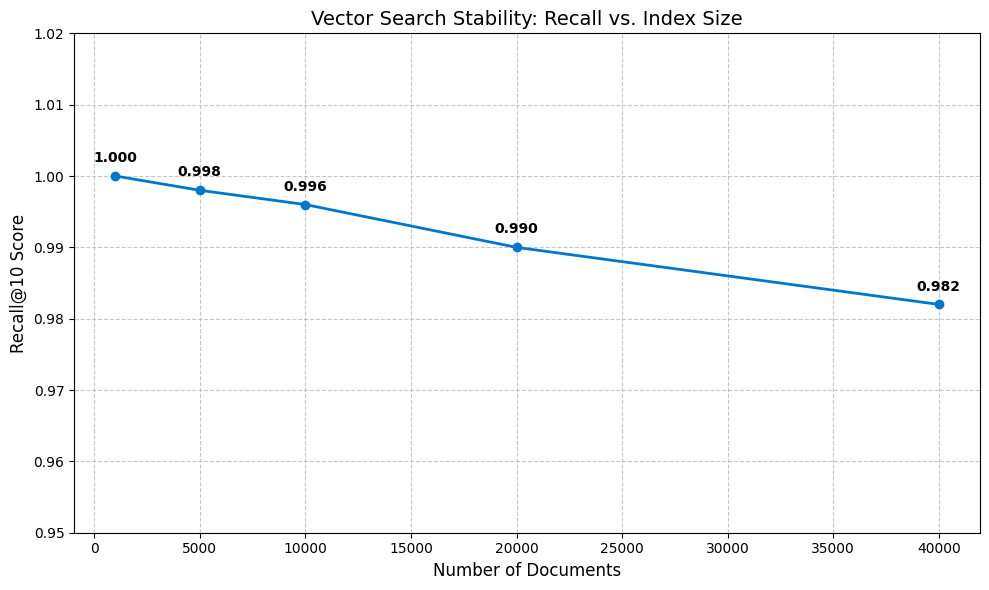

In [13]:
import matplotlib.pyplot as plt

# Check if we have results to plot
if 'results_df' not in locals():
    print("⚠️ No results found. Please run the Scale Test (Cell 12) first.")
else:
    # Plotting the Scale Test
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['Docs'], results_df['Recall'], marker='o', linestyle='-', color='#0077cc', linewidth=2)

    plt.title('Vector Search Stability: Recall vs. Index Size', fontsize=14)
    plt.xlabel('Number of Documents', fontsize=12)
    plt.ylabel('Recall@10 Score', fontsize=12)

    # --- FIX: Increase the upper limit to make room for labels ---
    # Was 1.005, now 1.02 to prevent the "1.000" text from being cut off
    plt.ylim(0.95, 1.02)

    plt.grid(True, linestyle='--', alpha=0.7)

    # Annotate points with the exact score
    for i, row in results_df.iterrows():
        plt.annotate(f"{row['Recall']:.3f}",
                     (row['Docs'], row['Recall']),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center',
                     fontweight='bold')

    plt.tight_layout()
    plt.show()

# --- The "Can it scale" Test (100k) ---

## We combine 3 categories to get enough data:
- Label 11: Album
- Label 12: Film
- Label 13: Written Work (Books)

In [14]:
print("🚀 Starting 'Go Big' 100k Scale Test...")
print("1. Reloading and filtering for Albums, Films, and Books...")

ds_big = load_dataset("dbpedia_14", split="train")
df_big = pd.DataFrame(ds_big)

# Filter for labels 11, 12, 13
df_big = df_big[df_big['label'].isin([11, 12, 13])]
print(f"✅ Combined Pool Size: {len(df_big)} documents (Should be ~120k)")

# Define the massive scale steps
big_scale_steps = [1000, 10000, 50000, 100000] #1,000, 10,000, 50,000, 100,000
big_results = []

for size in big_scale_steps:
    print(f"\n\n=== 🦖 Testing Massive Scale: {size} Documents ===")

    # 1. Resample from the BIG pool
    current_df = df_big.sample(size, random_state=42).reset_index(drop=True)

    # 2. Reset Index
    if client.indices.exists(index=index_name):
        client.indices.delete(index=index_name)

    client.indices.create(index=index_name, mappings=mapping)

    # 3. Bulk Index
    actions = []
    for i, row in current_df.iterrows():
        actions.append({
            "_index": index_name,
            "_id": str(i),
            "_source": {"title": row['title'], "content": row['content']}
        })

    # Larger chunk size for speed
    helpers.bulk(client, actions, chunk_size=1000, raise_on_error=False)
    print(f"Indexed {size} docs. Waiting 20s for inference...")
    time.sleep(20)

    # 4. Recall Test
    batch_indices = np.random.choice(len(current_df), 50, replace=False)
    batch_scores = []

    for idx in batch_indices:
        q_text = current_df.iloc[idx]['content']

        # Ground Truth (Flat)
        truth = client.search(
            index=index_name,
            query={"semantic": {"field": "content.raw", "query": q_text}},
            size=10, _source=False
        )
        t_ids = [h['_id'] for h in truth['hits']['hits']]

        # Test (HNSW)
        test = client.search(
            index=index_name,
            query={"semantic": {"field": "content", "query": q_text}},
            size=10, _source=False
        )
        test_ids = [h['_id'] for h in test['hits']['hits']]

        matches = set(t_ids).intersection(set(test_ids))
        batch_scores.append(len(matches) / 10)

    final_score = np.mean(batch_scores)
    print(f"📊 Score for {size} docs: {final_score:.4f}")
    big_results.append({"Docs": size, "Recall": final_score})

print("\n\n🏆 --- Massive Scale Test Results ---")
print(pd.DataFrame(big_results))

results_df_big = pd.DataFrame(big_results)
print(results_df_big)

🚀 Starting 'Go Big' 100k Scale Test...
1. Reloading and filtering for Albums, Films, and Books...
✅ Combined Pool Size: 120000 documents (Should be ~120k)


=== 🦖 Testing Massive Scale: 1000 Documents ===
Indexed 1000 docs. Waiting 20s for inference...
📊 Score for 1000 docs: 1.0000


=== 🦖 Testing Massive Scale: 10000 Documents ===
Indexed 10000 docs. Waiting 20s for inference...
📊 Score for 10000 docs: 0.9980


=== 🦖 Testing Massive Scale: 50000 Documents ===
Indexed 50000 docs. Waiting 20s for inference...
📊 Score for 50000 docs: 0.9980


=== 🦖 Testing Massive Scale: 100000 Documents ===
Indexed 100000 docs. Waiting 20s for inference...
📊 Score for 100000 docs: 0.9880


🏆 --- Massive Scale Test Results ---
     Docs  Recall
0    1000   1.000
1   10000   0.998
2   50000   0.998
3  100000   0.988
     Docs  Recall
0    1000   1.000
1   10000   0.998
2   50000   0.998
3  100000   0.988


# Lets Chart it!

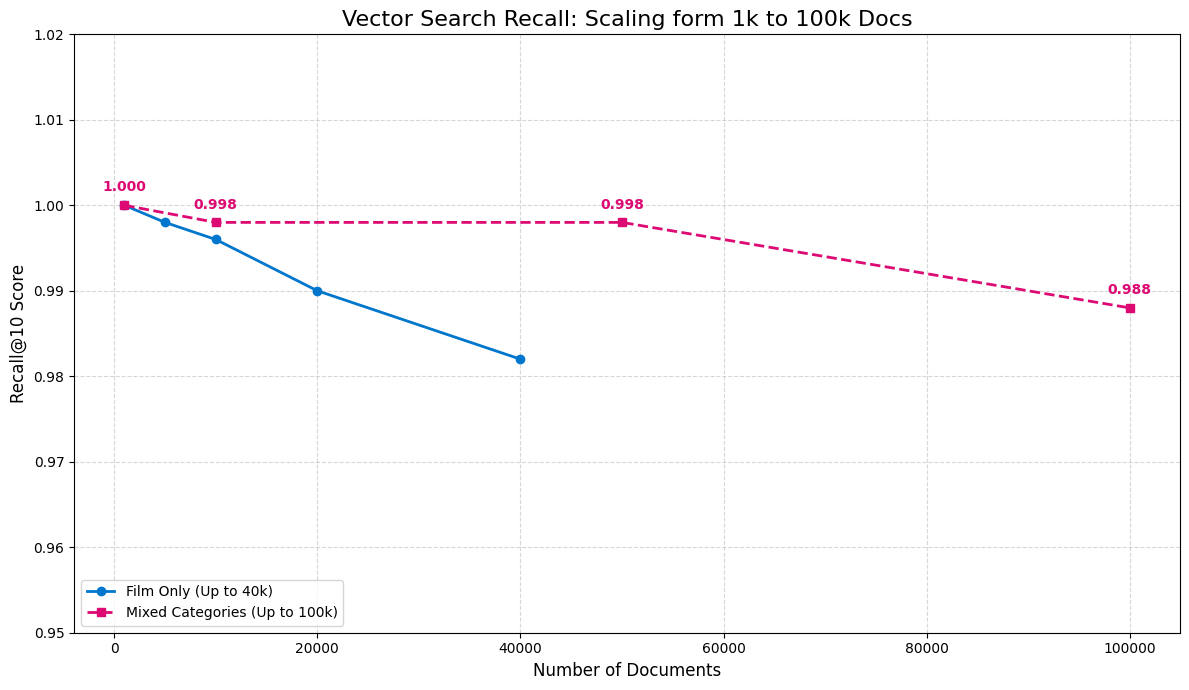

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Combine DataFrames for a unified view
# We assume 'results_df' exists from the first test and 'results_df_big' from the second.
if 'results_df' in locals() and 'results_df_big' in locals():

    plt.figure(figsize=(12, 7))

    # Plot 1: The Standard "Film Only" Test (Blue)
    plt.plot(results_df['Docs'], results_df['Recall'],
             marker='o', linestyle='-', color='#0077cc', linewidth=2, label='Film Only (Up to 40k)')

    # Plot 2: The "Go Big" Mixed Category Test (Red/Pink)
    # We plot this second so it layers on top if there is overlap
    plt.plot(results_df_big['Docs'], results_df_big['Recall'],
             marker='s', linestyle='--', color='#DD0A73', linewidth=2, label='Mixed Categories (Up to 100k)')

    plt.title('Vector Search Recall: Scaling form 1k to 100k Docs', fontsize=16)
    plt.xlabel('Number of Documents', fontsize=12)
    plt.ylabel('Recall@10 Score', fontsize=12)
    plt.legend(loc='lower left')

    # Dynamic Y-Limit to show detail at the top
    # We find the lowest score across BOTH tests to set the bottom limit
    min_score = min(results_df['Recall'].min(), results_df_big['Recall'].min())
    plt.ylim(min(0.95, min_score - 0.01), 1.02)

    plt.grid(True, linestyle='--', alpha=0.5)

    # Annotate the "Go Big" points specifically since they are the new context
    for i, row in results_df_big.iterrows():
        plt.annotate(f"{row['Recall']:.3f}",
                     (row['Docs'], row['Recall']),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center',
                     color='#DD0A73',
                     fontweight='bold')

    plt.tight_layout()
    plt.show()

else:
    print("⚠️ Missing data. Please ensure you have run both Scale Test cells (Cell 12 and Cell 15).")

# --- The throw the whole thing at it - test 560k) ---
We load the entire DBPedia-14 training set.

Total Docs: 560,000

```
                   (        )             )  (        )          
                   )\ )  ( /(   *   )  ( /(  )\ )  ( /(  (       
 (    (   (   (   (()/(  )\())` )  /(  )\())(()/(  )\()) )\ )    
 )\   )\  )\  )\   /(_))((_)\  ( )(_))((_)\  /(_))((_)\ (()/(    
((_) ((_)((_)((_) (_)) __ ((_)(_(_())  _((_)(_))   _((_) /(_))_  
| __|\ \ / / | __|| _ \\ \ / /|_   _| | || ||_ _| | \| |(_)) __|
| _|  \ V /  | _| |   / \ V /   | |   | __ | | |  | .` |  | (_ |
|___|  \_/   |___||_|_\  |_|    |_|   |_||_||___| |_|\_|   \___|
                                                                 
                                                                 

In [16]:
# --- THE "WHOLE ENCHILADA" SCALE TEST (560k) ---
# We load the entire DBPedia-14 training set.
# Total Docs: 560,000

print("🚀 Starting 'Whole Enchilada' Scale Test...")
print("1. Reloading the ENTIRE dataset...")

# Load everything (No filtering by label)
ds_all = load_dataset("dbpedia_14", split="train")
df_all = pd.DataFrame(ds_all)

print(f"✅ Total Pool Size: {len(df_all):,} documents.")

# Define the massive scale steps
mega_scale_steps = [10000, 50000, 100000, 200000, 400000, 560000]
mega_results = []

for size in mega_scale_steps:
    print(f"\n\n=== 🦖 Testing Mega Scale: {size:,} Documents ===")

    # Start the Timer
    step_start_time = time.time()

    # 1. Resample from the FULL pool
    if size == 560000:
        current_df = df_all.reset_index(drop=True)
    else:
        current_df = df_all.sample(size, random_state=42).reset_index(drop=True)

    # 2. Reset Index
    if client.indices.exists(index=index_name):
        client.indices.delete(index=index_name)

    client.indices.create(index=index_name, mappings=mapping)

    # 3. Bulk Index
    actions = []
    # Generator loop to save memory
    for i, row in current_df.iterrows():
        actions.append({
            "_index": index_name,
            "_id": str(i),
            "_source": {"title": row['title'], "content": row['content']}
        })

    print(f"Uploading {size:,} documents...")

    success, errors = helpers.bulk(client, actions, chunk_size=1000, raise_on_error=False)

    if errors:
        print(f"⚠️ Warning: {len(errors):,} docs failed to index.")

    print(f"✅ Indexed {success:,} docs. Waiting 60s for inference/indexing to settle...")
    time.sleep(60)

    # 4. Recall Test
    batch_indices = np.random.choice(len(current_df), 100, replace=False)
    batch_scores = []

    print("Running 100 queries...")
    for idx in batch_indices:
        q_text = current_df.iloc[idx]['content']

        # Ground Truth (Flat)
        truth = client.search(
            index=index_name,
            query={"semantic": {"field": "content.raw", "query": q_text}},
            size=10, _source=False
        )
        t_ids = [h['_id'] for h in truth['hits']['hits']]

        # Test (HNSW)
        test = client.search(
            index=index_name,
            query={"semantic": {"field": "content", "query": q_text}},
            size=10, _source=False
        )
        test_ids = [h['_id'] for h in test['hits']['hits']]

        matches = set(t_ids).intersection(set(test_ids))
        batch_scores.append(len(matches) / 10)

    final_score = np.mean(batch_scores)

    # Stop the Timer
    step_end_time = time.time()
    duration_seconds = step_end_time - step_start_time
    duration_minutes = duration_seconds / 60

    print(f"📊 Score for {size:,} docs: {final_score:.4f}")
    print(f"⏱️ Time taken: {duration_seconds:.1f}s ({duration_minutes:.1f} min)")

    mega_results.append({
        "Docs": size,
        "Recall": final_score,
        "Time (s)": round(duration_seconds, 1)
    })

print("\n\n🏆 --- Mega Scale Test Results ---")
results_df_mega = pd.DataFrame(mega_results)
print(results_df_mega)

🚀 Starting 'Whole Enchilada' Scale Test...
1. Reloading the ENTIRE dataset...
✅ Total Pool Size: 560,000 documents.


=== 🦖 Testing Mega Scale: 10,000 Documents ===
Uploading 10,000 documents...
✅ Indexed 10,000 docs. Waiting 60s for inference/indexing to settle...
Running 100 queries...
📊 Score for 10,000 docs: 1.0000
⏱️ Time taken: 150.6s (2.5 min)


=== 🦖 Testing Mega Scale: 50,000 Documents ===
Uploading 50,000 documents...
✅ Indexed 50,000 docs. Waiting 60s for inference/indexing to settle...
Running 100 queries...
📊 Score for 50,000 docs: 0.9950
⏱️ Time taken: 435.7s (7.3 min)


=== 🦖 Testing Mega Scale: 100,000 Documents ===
Uploading 100,000 documents...
✅ Indexed 100,000 docs. Waiting 60s for inference/indexing to settle...
Running 100 queries...
📊 Score for 100,000 docs: 0.9970
⏱️ Time taken: 850.5s (14.2 min)


=== 🦖 Testing Mega Scale: 200,000 Documents ===
Uploading 200,000 documents...
✅ Indexed 200,000 docs. Waiting 60s for inference/indexing to settle...
Running 100 que

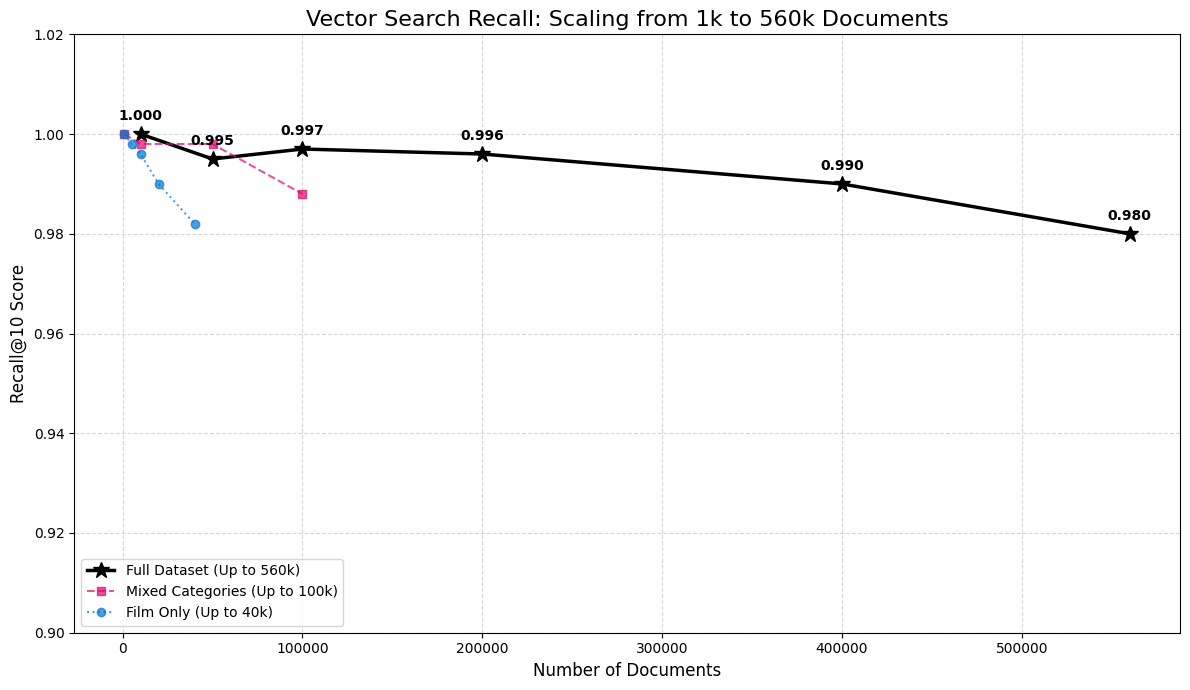

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12, 7))

# 1. Plot the "Mega" run (560k)
# We plot this first so it sets the scale
if 'results_df_mega' in locals():
    plt.plot(results_df_mega['Docs'], results_df_mega['Recall'],
             marker='*', markersize=12, linestyle='-', color='#000000', linewidth=2.5, label='Full Dataset (Up to 560k)')

    # Annotate the Mega points
    for i, row in results_df_mega.iterrows():
        plt.annotate(f"{row['Recall']:.3f}",
                     (row['Docs'], row['Recall']),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center',
                     fontweight='bold')

# 2. Plot the previous "Go Big" run (100k) for context
if 'results_df_big' in locals():
    plt.plot(results_df_big['Docs'], results_df_big['Recall'],
             marker='s', linestyle='--', color='#DD0A73', linewidth=1.5, alpha=0.7, label='Mixed Categories (Up to 100k)')

# 3. Plot the original "Film" run (40k)
if 'results_df' in locals():
    plt.plot(results_df['Docs'], results_df['Recall'],
             marker='o', linestyle=':', color='#0077cc', linewidth=1.5, alpha=0.7, label='Film Only (Up to 40k)')

plt.title('Vector Search Recall: Scaling from 1k to 560k Documents', fontsize=16)
plt.xlabel('Number of Documents', fontsize=12)
plt.ylabel('Recall@10 Score', fontsize=12)
plt.legend(loc='lower left')

plt.ylim(0.90, 1.02)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Lets Compare!

In [ ]:
# --- 1. Define E5 Mapping ---
# We switch the inference ID to E5 Small.
index_name_e5 = "movies-recall-e5"

mapping_e5 = {
    "properties": {
        "title": {"type": "text"},
        "content": {
            "type": "semantic_text",
            "inference_id": ".multilingual-e5-small-elasticsearch",
            "fields": {
                "raw": {
                    "type": "semantic_text",
                    "inference_id": ".multilingual-e5-small-elasticsearch",
                    "index_options": {
                        "dense_vector": {
                            "type": "flat" # Ground Truth
                        }
                    }
                }
            }
        }
    }
}

print(f"✅ Mapping prepared for model: .multilingual-e5-small-elasticsearch")
print(f"Target Index: {index_name_e5}")

In [ ]:
# --- THE "WHOLE ENCHILADA" (E5 Model Version) ---
# Repeating the massive scale test to compare model performance.

print(f"🚀 Starting E5 Scale Test on index: {index_name_e5}")

# We verify the dataset is loaded (from previous cells)
if 'df_all' not in locals():
    print("🔄 Reloading DBPedia dataset...")
    ds_all = load_dataset("dbpedia_14", split="train")
    df_all = pd.DataFrame(ds_all)

# Use the same scale steps as the previous Mega test
# If you didn't run Cell 18, we define them here:
mega_scale_steps = [10000, 50000, 100000, 200000, 400000, 560000]
e5_results = []

for size in mega_scale_steps:
    print(f"\n\n=== 🧪 Testing E5 Scale: {size:,} Documents ===")
    step_start = time.time()

    # 1. Resample
    if size == 560000:
        current_df = df_all.reset_index(drop=True)
    else:
        current_df = df_all.sample(size, random_state=42).reset_index(drop=True)

    # 2. Reset Index (E5 Version)
    if client.indices.exists(index=index_name_e5):
        client.indices.delete(index=index_name_e5)

    client.indices.create(index=index_name_e5, mappings=mapping_e5)

    # 3. Bulk Index
    actions = []
    for i, row in current_df.iterrows():
        actions.append({
            "_index": index_name_e5,
            "_id": str(i),
            "_source": {"title": row['title'], "content": row['content']}
        })

    print(f"Uploading {size:,} docs to {index_name_e5}...")
    helpers.bulk(client, actions, chunk_size=1000, raise_on_error=False)

    print(f"✅ Indexed. Waiting 60s for inference...")
    time.sleep(60)

    # 4. Recall Test
    batch_indices = np.random.choice(len(current_df), 100, replace=False)
    batch_scores = []

    for idx in batch_indices:
        q_text = current_df.iloc[idx]['content']

        # E5 Ground Truth
        truth = client.search(
            index=index_name_e5,
            query={"semantic": {"field": "content.raw", "query": q_text}},
            size=10, _source=False
        )
        t_ids = [h['_id'] for h in truth['hits']['hits']]

        # E5 Test (HNSW)
        test = client.search(
            index=index_name_e5,
            query={"semantic": {"field": "content", "query": q_text}},
            size=10, _source=False
        )
        test_ids = [h['_id'] for h in test['hits']['hits']]

        matches = set(t_ids).intersection(set(test_ids))
        batch_scores.append(len(matches) / 10)

    final_score = np.mean(batch_scores)

    # Timing
    step_end = time.time()
    duration = step_end - step_start

    print(f"📊 E5 Score for {size:,} docs: {final_score:.4f}")
    e5_results.append({
        "Docs": size,
        "Recall": final_score,
        "Model": "E5 Small",
        "Time": duration
    })

print("\n\n🏆 --- E5 Scale Test Results ---")
results_df_e5 = pd.DataFrame(e5_results)
print(results_df_e5)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12, 7))

# 1. Plot Jina AI v3 (From previous Mega run)
# We check if 'results_df_mega' exists from Cell 18
if 'results_df_mega' in locals():
    plt.plot(results_df_mega['Docs'], results_df_mega['Recall'],
             marker='o', linestyle='-', color='#0077cc', linewidth=2, label='Jina AI v3')

    # Annotate Jina Points
    for i, row in results_df_mega.iterrows():
        plt.annotate(f"{row['Recall']:.3f}",
                     (row['Docs'], row['Recall']),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center', fontsize=9, color='#0077cc', fontweight='bold')

# 2. Plot E5 Small (From this run)
if 'results_df_e5' in locals():
    plt.plot(results_df_e5['Docs'], results_df_e5['Recall'],
             marker='s', linestyle='--', color='#00BFB3', linewidth=2, label='E5 Small')

    # Annotate E5 Points
    for i, row in results_df_e5.iterrows():
        # Offset text slightly down to avoid overlap
        plt.annotate(f"{row['Recall']:.3f}",
                     (row['Docs'], row['Recall']),
                     textcoords="offset points",
                     xytext=(0,-15),
                     ha='center', fontsize=9, color='#00BFB3', fontweight='bold')

plt.title('Model Showdown: Recall vs. Scale (560k Docs)', fontsize=16)
plt.xlabel('Number of Documents', fontsize=12)
plt.ylabel('Recall@10 Score', fontsize=12)
plt.legend(loc='lower left', fontsize=11)

plt.ylim(0.90, 1.02)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()